<a id="title_ID"></a>
# Using Kepler FITS Data to Create a Light Curve 
<br>
This notebook tutorial demonstrates the process of loading and extracting information from Kepler light curve FITS files to plot a light curve and display the photometric aperture. 
<img style="float: right;" src="light_curve_tres2.png" alt="light_curve_tres2" width="800px"/> 
### Table of Contents
<div style="text-align: left"> <br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [Reading FITS Extensions](#header_ID) <br> [Plotting a Light Curve](#lightcurve_ID) <br> [The Aperture Extension](#aperture_ID) <br> [Additional Resources](#resources_ID) <br> [About this Notebook](#about_ID) </div>

***

<a id="intro_ID"></a>
## Introduction

**Light curve background:**
A light curve is a plot of flux versus time that shows the variability of light output from an object. This is one way to find planets periodically transitting a star. The light curves made here will plot the corrected and uncorrected fluxes from Kepler data of object KIC 11446443 (TRES-2). 

**Some notes about the file:** kplr_011446443-2009131110544_slc.fits
<br>The filename contains phrases for identification, where
 - kplr = Kepler 
 - 011446443 = Kepler ID number
 - 2009131110544 = year 2009, day 131, time 11:05:44
 - slc = short cadence

**Defining some terms:**
 - **Cadence:** the frequency with which summed data are read out. Files are either short cadence (a 1 minute sum) or long cadence (a 30 minute sum).
 - **SAP Flux:** Simple Aperture Photometry flux; flux after summing the calibrated pixels within the optimal aperture
 - **PDCSAP Flux:** Pre-search Data Conditioned Simple Aperture Photometry; these are the flux values nominally corrected for instrumental variations. 
 - **BJD:** Barycentric Julian Day; this is the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System Barycentre (center of mass of the Solar System).
 - **HDU:** Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension. 

For more information about the Kepler mission and collected data, visit the [Kepler archive page](https://archive.stsci.edu/kepler/). To read more details about light curves and relevant data terms, look in the [Kepler archive manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=16).

[Top of Page](#title_ID)

***

<a id="imports_ID"></a>
## Imports
Let's start by importing some libraries to the environment: 
- *matplotlib notebook* for creating interactive plots 
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib* for plotting data

In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt

[Top of Page](#title_ID)

***

<a id="data_ID"></a>
## Getting the Data
Start by importing libraries from Astroquery. For a longer, more detailed description using of Astroquery, please visit this [tutorial](https://github.com/spacetelescope/MAST-API-Notebooks/blob/master/MUG2018_APITutorial_Astroquery.ipynb) or read the Astroquery [documentation](https://astroquery.readthedocs.io/en/latest/#). 

In [2]:
from astroquery.mast import Mast
from astroquery.mast import Observations

<br>Next, we need to find the data file. This is similar to searching for the data using the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in that we will be using certain keywords to find the file. The target name of the object we are looking for is kplr011446443, collected by the Kepler spacecraft.

In [3]:
keplerObs = Observations.query_criteria(target_name='kplr011446443', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])
yourProd = Observations.filter_products(keplerProds, extension='kplr011446443-2009131110544_slc.fits', 
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str6,str10,str36,str60,str1,str110,str9,str28,str1,str1,str6,str1,str7,str44,int64,str10
9000210988,Kepler,timeseries,kplr011446443_sc_Q113313330333033302,Lightcurve Short Cadence (CSC) - Q0,C,mast:Kepler/url/missions/kepler/lightcurves/0114/011446443/kplr011446443-2009131110544_slc.fits,SCIENCE,--,--,--,Kepler,--,EX_STKS,kplr011446443-2009131110544_slc.fits,1457280,9000210988


<br>Now that we've found the data file, we can download it using the reults shown in the table above:

In [4]:
Observations.download_products(yourProd, mrp_only = False, cache = False)   #'/Users/jbunnell/Desktop/jb_notebooks', 

Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits,COMPLETE,None,None


<br>Click on the blue URL above to download the file. You are now ready to complete the rest of the notebook.

[Top of Page](#title_ID)

***

<a id="header_ID"></a>
## Reading FITS Extensions
<br>Now that we have the file, we can start working with the data. We will begin by assigning a shorter name to the file to make it easier to use. Then, using the info function from astropy.io.fits, we can see some information about the FITS Header Data Units:

In [5]:
filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


 - **No. 0 (Primary): **
 <br>This HDU contains meta-data related to the entire file.
 - **No. 1 (Light curve): **
 <br>This HDU contains a binary table is the binary extension that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.
 - **No. 2 (Aperture): **
 <br>This HDU contains the image extension with data collected from the aperture. We will also use this to display a bitmask plot that visually represents the optimal aperture used to create the SAP_FLUX column in HDU1.

For more detailed information about header extensions, look [here](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=17).

<br>Let's say we wanted to see more information about the extensions than what the fits.info command gave us. For example, we can access all the information stored in the header of the Binary Table extension (No. 1, LIGHTCURVE). The following line opens the FITS file, writes the first HDU extension into header1, and then closes the file. Print(repr( )) formats the output into neat, readable columns. 

In [6]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[8:23]))

TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TFORM2  = 'E       '           / column format: 32-bit floating point           
TUNIT2  = 'd       '           / column units: day                              
TDISP2  = 'E13.6   '           / column display format                          
TTYPE3  = 'CADENCENO'          / column title: unique cadence number            
TFORM3  = 'J       '           / column format: signed 32-bit integer           
TDISP3  = 'I10     '           / column display format                          
TTYPE4  = 'SAP_FLUX'           / column title: aperture photometry flux         
TFORM4  = 'E       '        

<br> We can also view a table of the data from the Binary Table extension. This is where we can find the flux and time columns to be plotted later. Here only the first four rows of the table are displayed:

In [7]:
with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52992386784899,0.00096672785,5501,401288.16,91.51187,2598.1086,0.5752603,406100.9,127.528824,0,nan,nan,nan,nan,621.2181187542091,0.0002101067,848.8972881655714,0.00029125414,0.0002031729,-0.0025746305
120.53060508973431,0.00096674974,5502,401425.53,91.53448,2598.0261,0.57525027,406242.22,125.212105,0,nan,nan,nan,nan,621.2190207168474,0.00021018942,848.8935790650855,0.0002912894,0.00021144762,-0.0025837936
120.53128621167707,0.0009667717,5503,401172.0,91.517265,2597.9438,0.5752402,405984.03,123.31339,0,nan,nan,nan,nan,621.2179228162092,0.00021032244,848.894852260174,0.0002914222,0.00021972114,-0.0025929555
120.53196743356966,0.00096679357,5504,401473.62,91.53064,2597.8613,0.5752302,406293.0,121.84987,0,nan,nan,nan,nan,621.2198263101714,0.00021020704,848.8961790332079,0.00029115527,0.00022799587,-0.0026021185


[Top of Page](#title_ID)

***

<a id="lightcurve_ID"></a>
## Plotting a Light Curve
<br>Now that we have seen and accessed the data, we can begin to plot a light curve:

1. Open the file using command fits.open. This will allow the program to read and store the data we will manipulate to be plotted. Here we've also renamed the file with a phrase that is easier to handle (see line 1). 
<br>
<br>
2. Start by calibrating the time. Because the Kepler data is in BKJD (Kepler Barycentric Julian Day) we need to convert it to time in Julian Days (BJD) if we want to be able to compare it to other outside data. For a more detailed explanation about time conversions, visit the [page 13](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=13) or [page 17](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=17) of the Kepler Archive Manual.
<br>
    - Read in the BJDREF times, both the integer (BJDREFI) and the floating point (BJDREFF). These are found as columns of data in the *binary extension* of the header. 
<br>
<br>
3. Read in the columns of times and fluxes (both uncorrected and corrected) from the data.

In [8]:
with fits.open(filename, mode="readonly") as hdulist:
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']

    # Read in the columns of data.
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

4. Now that the appropriate data has been read and stored, convert the times to BJDS by adding the BJDREF times to the data of times. 
<br>
<br>
5. Finally, we can plot the fluxes against time. We can also set a title and add a legend to the plot. We can label our fluxes accordingly and assign them colors and styles ("-k" for a black line, "-b" for a blue line).

<IPython.core.display.Javascript object>


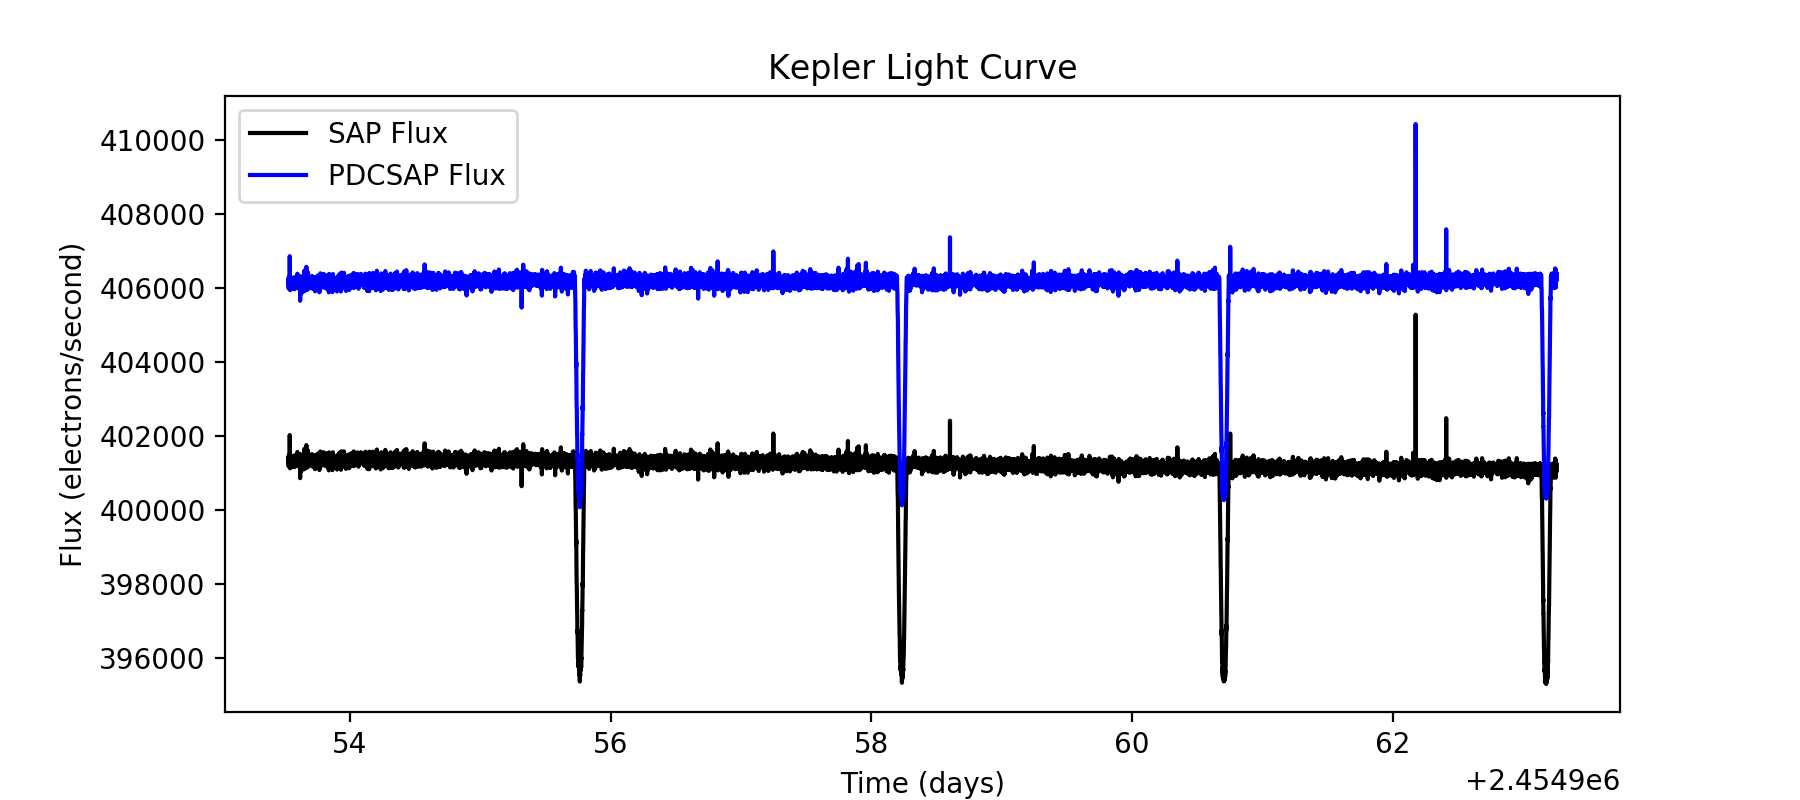

In [9]:
# Convert the time array to full BJD by adding the offset back in.
bjds = times + bjdrefi + bjdreff 

plt.figure(figsize=(9,4))

# Plot the time, uncorrected and corrected fluxes.
plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.show()

[Top of Page](#title_ID)

***

<a id="aperture_ID"></a>
## The Aperture Extension
<br>We can also make a plot of the third HDU; the image extension (No. 2, APERTURE). This data is stored as an array of integers that encodes which pixels were collected from the spacecraft and which were used in the optimal aperture (look here for more information on the [aperture extension](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=20)). 
<br> 
<br>First, we need to re-open the FITS file and access the header. Next, we read in the image extension and print it as an array:

In [10]:
with fits.open(filename) as hdulist: 
    imgdata = hdulist[2].data
    
print(imgdata)

[[1 1 1 1 1 1 1 0]
 [1 1 1 5 5 5 5 1]
 [1 1 5 5 7 7 5 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 7 5]
 [1 1 5 7 7 7 5 5]
 [1 1 5 5 7 5 5 1]
 [1 1 1 5 5 5 1 0]]


We can also show the data in a plot:

<IPython.core.display.Javascript object>


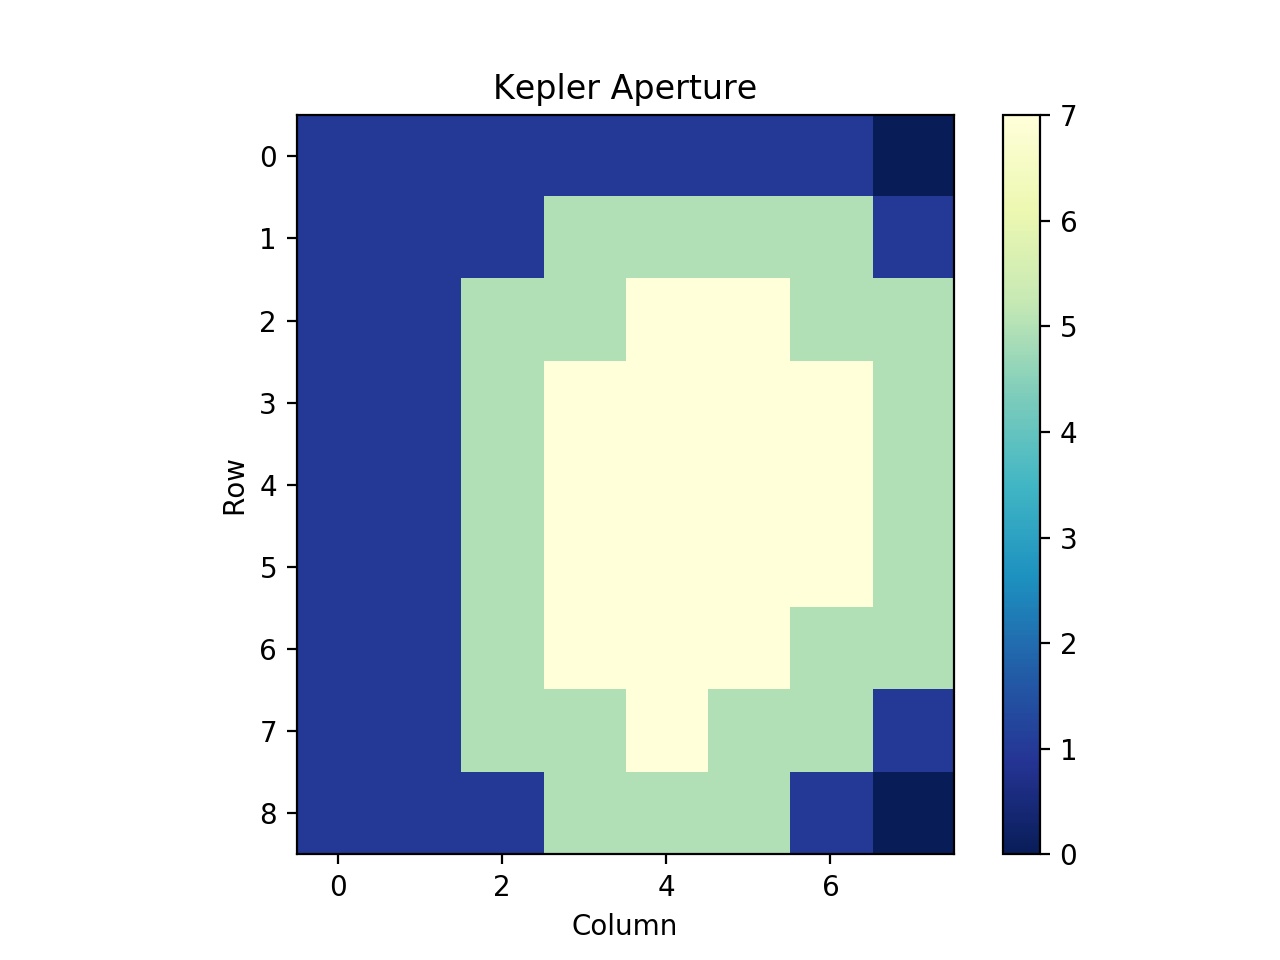

In [11]:
plt.figure(2)
plt.title('Kepler Aperture')
plt.imshow(imgdata, cmap=plt.cm.YlGnBu_r)
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar()

[Top of Page](#title_ID)

***

<a id="resources_ID"></a>
## Additional Resources
For more information about the MAST archive and details about mission data:
<br>
<br>MAST API:
<br>https://mast.stsci.edu/api/v0/index.html
<br>
<br>Kepler Archive Page (MAST):
<br>https://archive.stsci.edu/kepler/
<br>
<br>Kepler Archive Manual:
<br>https://archive.stsci.edu/kepler/manuals/archive_manual.pdf
<br>
<br>Exo.MAST website:
<br>https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html

***

<a id="about_ID"></a>
## About this Notebook
**Author:** Josie Bunnell, STScI SASP Intern
<br>**Updated On:** 08/10/2018

***

[Top of Page](#title_ID)
<img style="float: right;" src="stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 